In [6]:
# Import NumPy library for numerical computations and array/matrix operations
import numpy as np

# Import OpenCV library for image processing and computer vision tasks
# Used for reading images, resizing, filtering, edge detection, etc.
import cv2

# Import Matplotlib's pyplot module for displaying images and plotting graphs
# Commonly used to visualize images, histograms, and results
import matplotlib.pyplot as plt

# Import Sobel and Gaussian filter functions from SciPy's ndimage module
# sobel: used for edge detection by computing image gradients
# gaussian_filter: used for smoothing images and reducing noise
from scipy.ndimage import sobel, gaussian_filter


In [7]:
def harris_corners_from_scratch(gray_img, block_size=3, k=0.04, threshold_ratio=0.01):
    """
    Implements Harris Corner Detection from scratch on a grayscale image.

    Parameters:
    gray_img : 2D numpy array (grayscale image)
    block_size : size of the neighborhood window for structure tensor
    k : Harris detector free parameter (typically 0.04–0.06)
    threshold_ratio : ratio of max response used for thresholding
    """

    # --------------------------------------------------
    # Step 1: Compute image gradients (intensity changes)
    # --------------------------------------------------
    # Ix: gradient in x-direction (horizontal changes)
    Ix = sobel(gray_img, axis=1)

    # Iy: gradient in y-direction (vertical changes)
    Iy = sobel(gray_img, axis=0)

    # --------------------------------------------------
    # Step 2: Compute products of derivatives
    # These represent gradient information used in
    # the structure tensor (second-moment matrix)
    # --------------------------------------------------
    Ixx = gaussian_filter(Ix * Ix, sigma=1)  # Ix² smoothed
    Iyy = gaussian_filter(Iy * Iy, sigma=1)  # Iy² smoothed
    Ixy = gaussian_filter(Ix * Iy, sigma=1)  # IxIy smoothed

    # --------------------------------------------------
    # Step 3: Initialize structure tensor components
    # Sxx, Syy, Sxy will store summed values
    # over a local neighborhood for each pixel
    # --------------------------------------------------
    Sxx = np.zeros_like(gray_img)
    Syy = np.zeros_like(gray_img)
    Sxy = np.zeros_like(gray_img)

    # Half window size for neighborhood calculation
    half = block_size // 2

    # --------------------------------------------------
    # Step 4: Compute structure tensor sums
    # Sum gradient products inside block_size window
    # --------------------------------------------------
    for y in range(half, gray_img.shape[0] - half):
        for x in range(half, gray_img.shape[1] - half):

            # Sum Ix² values in the local window
            Sxx[y, x] = np.sum(Ixx[y-half:y+half+1, x-half:x+half+1])

            # Sum Iy² values in the local window
            Syy[y, x] = np.sum(Iyy[y-half:y+half+1, x-half:x+half+1])

            # Sum IxIy values in the local window
            Sxy[y, x] = np.sum(Ixy[y-half:y+half+1, x-half:x+half+1])

    # --------------------------------------------------
    # Step 5: Compute Harris corner response R
    # R = det(M) - k * (trace(M))²
    # --------------------------------------------------
    det = Sxx * Syy - Sxy ** 2     # Determinant of structure tensor
    trace = Sxx + Syy              # Trace of structure tensor
    R = det - k * trace ** 2       # Harris response value

    # --------------------------------------------------
    # Step 6: Thresholding
    # Keep only strong corner responses
    # --------------------------------------------------
    threshold = threshold_ratio * R.max()
    corners = []

    # --------------------------------------------------
    # Step 7: Non-Maximum Suppression
    # Keep pixel only if it is a local maximum
    # --------------------------------------------------
    for y in range(1, R.shape[0] - 1):
        for x in range(1, R.shape[1] - 1):

            # Check if response is above threshold
            if R[y, x] > threshold:

                # Check if it is the maximum in 3×3 neighborhood
                if R[y, x] == np.max(R[y-1:y+2, x-1:x+2]):
                    corners.append((y, x))

    # --------------------------------------------------
    # Step 8: Return detected corner points
    # --------------------------------------------------
    return corners


In [8]:
def fast_corners_from_scratch(gray_img, threshold=30, n=9):

    # Ensure image is uint8
    gray_img = gray_img.astype(np.uint8)
    height, width = gray_img.shape
    corners = []

    # FAST circle offsets (radius = 3)
    circle = [
        (0, 3), (1, 3), (2, 2), (3, 1), (3, 0), (3, -1), (2, -2), (1, -3),
        (0, -3), (-1, -3), (-2, -2), (-3, -1), (-3, 0), (-3, 1), (-2, 2), (-1, 3)
    ]

    # Iterate over valid pixels
    for y in range(3, height - 3):
        for x in range(3, width - 3):

            # Center pixel intensity
            center = int(gray_img[y, x])

            # Counters for consecutive pixels
            consec_bright = 0
            consec_dark = 0
            max_bright = 0
            max_dark = 0

            # Check pixels on the circle
            for dx, dy in circle:
                p = int(gray_img[y + dy, x + dx])

                # Compare with threshold
                if p > center + threshold:
                    consec_bright += 1
                    consec_dark = 0
                elif p < center - threshold:
                    consec_dark += 1
                    consec_bright = 0
                else:
                    consec_bright = consec_dark = 0

                # Track maximum streaks
                max_bright = max(max_bright, consec_bright)
                max_dark = max(max_dark, consec_dark)

            # Mark corner if condition satisfied
            if max_bright >= n or max_dark >= n:
                corners.append((y, x))

    # Return detected corners
    return corners


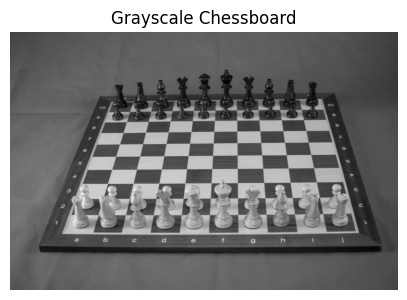

In [9]:
# Path to input image
img_path = "chessboard.jpg"   # Colab path

# Read image using OpenCV
original = cv2.imread(img_path)

# Check if image was loaded
if original is None:
    raise FileNotFoundError("Chessboard image not found")

# Convert image to grayscale
gray = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)

# Display grayscale image
plt.figure(figsize=(5,5))
plt.imshow(gray, cmap="gray")
plt.title("Grayscale Chessboard")
plt.axis("off")
plt.show()


In [10]:
# Harris corner detection
harris_pts = harris_corners_from_scratch(gray.astype(np.float32))

# FAST corner detection
fast_pts = fast_corners_from_scratch(gray, threshold=30, n=9)

# Display corner counts
print("Harris corners:", len(harris_pts))
print("FAST corners:", len(fast_pts))


Harris corners: 483
FAST corners: 964


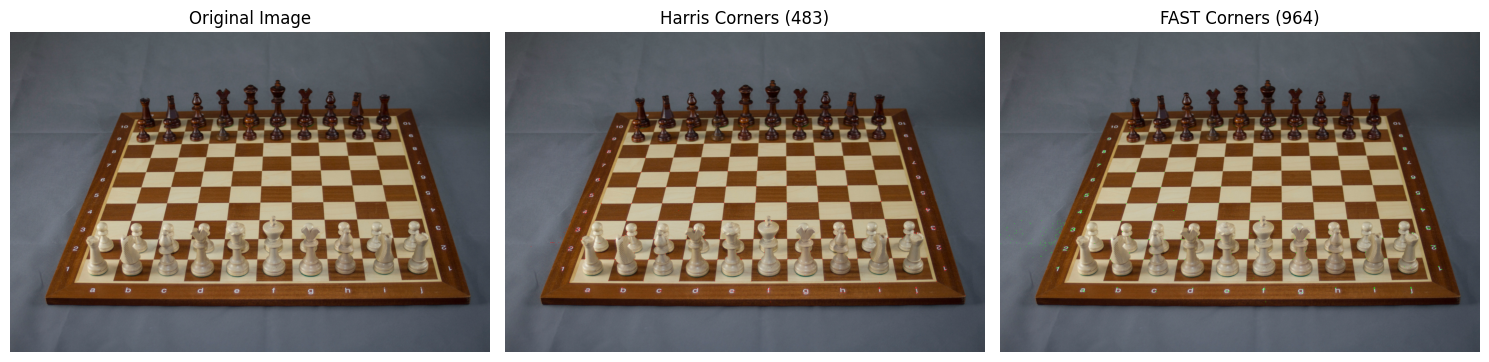

In [11]:
img_harris = original.copy()
for y, x in harris_pts:
    cv2.circle(img_harris, (x, y), 3, (0, 0, 255), -1)

img_fast = original.copy()
for y, x in fast_pts:
    cv2.circle(img_fast, (x, y), 3, (0, 255, 0), -1)

plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(img_harris, cv2.COLOR_BGR2RGB))
plt.title(f"Harris Corners ({len(harris_pts)})")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_fast, cv2.COLOR_BGR2RGB))
plt.title(f"FAST Corners ({len(fast_pts)})")
plt.axis("off")

plt.tight_layout()
plt.show()